In [1]:
# ================================================================
# WALMART SALES FORECASTING - MODEL BUILDING
# Author: Daniel Kattoula
# Date: January 2026
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Prophet for forecasting
from prophet import Prophet

# Sklearn for metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" All libraries imported successfully!")

 All libraries imported successfully!


 Data loaded and aggregated successfully!

Dataset shape: (143, 2)
Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00

First few rows:
        Date        Sales
0 2010-02-05  49750740.50
1 2010-02-12  48336677.63
2 2010-02-19  48276993.78
3 2010-02-26  43968571.13
4 2010-03-05  46871470.30


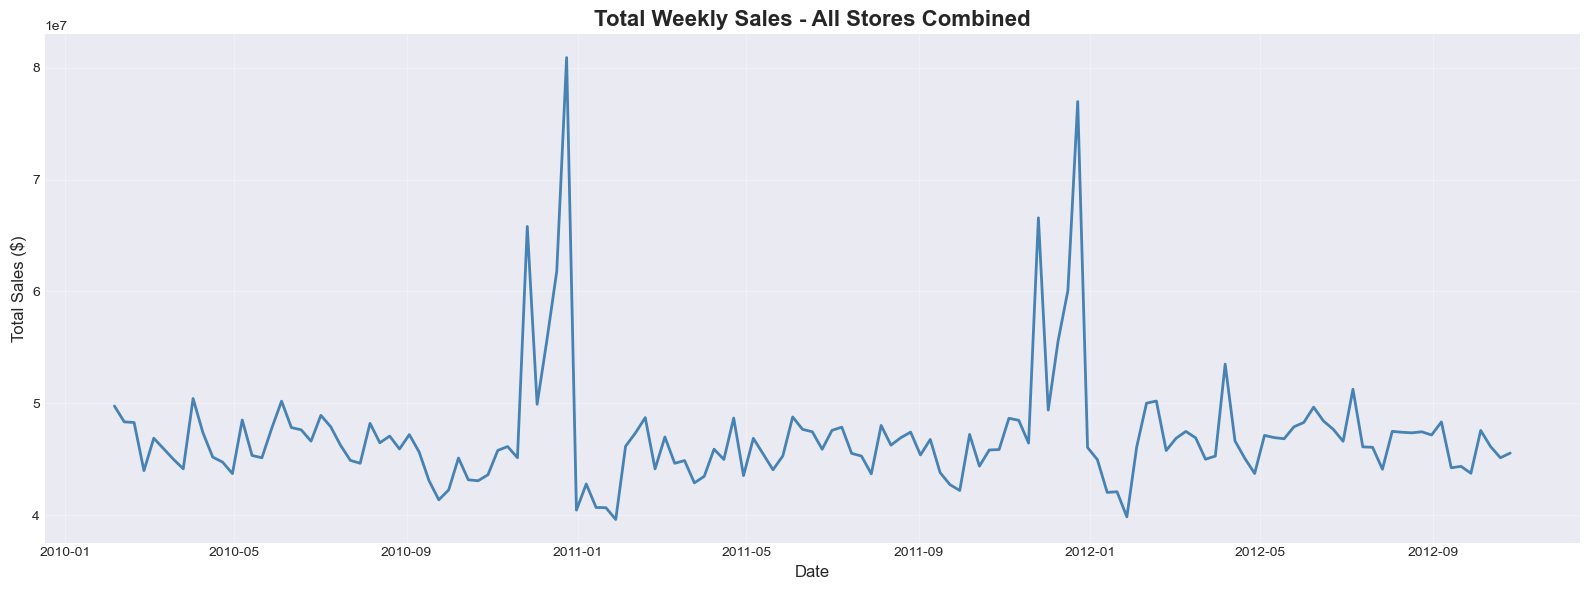

In [2]:
# Load the data
df = pd.read_csv('train.csv')

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate to total sales per week (all stores combined)
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
weekly_sales.columns = ['Date', 'Sales']

# Sort by date
weekly_sales = weekly_sales.sort_values('Date').reset_index(drop=True)

print(" Data loaded and aggregated successfully!")
print(f"\nDataset shape: {weekly_sales.shape}")
print(f"Date range: {weekly_sales['Date'].min()} to {weekly_sales['Date'].max()}")
print(f"\nFirst few rows:")
print(weekly_sales.head())

# Visualize the full time series
plt.figure(figsize=(16, 6))
plt.plot(weekly_sales['Date'], weekly_sales['Sales'], linewidth=2, color='steelblue')
plt.title('Total Weekly Sales - All Stores Combined', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('full_time_series.png', dpi=300, bbox_inches='tight')
plt.show()


TRAIN-TEST SPLIT

Training set: 135 weeks
  Date range: 2010-02-05 00:00:00 to 2012-08-31 00:00:00

Test set: 8 weeks
  Date range: 2012-09-07 00:00:00 to 2012-10-26 00:00:00


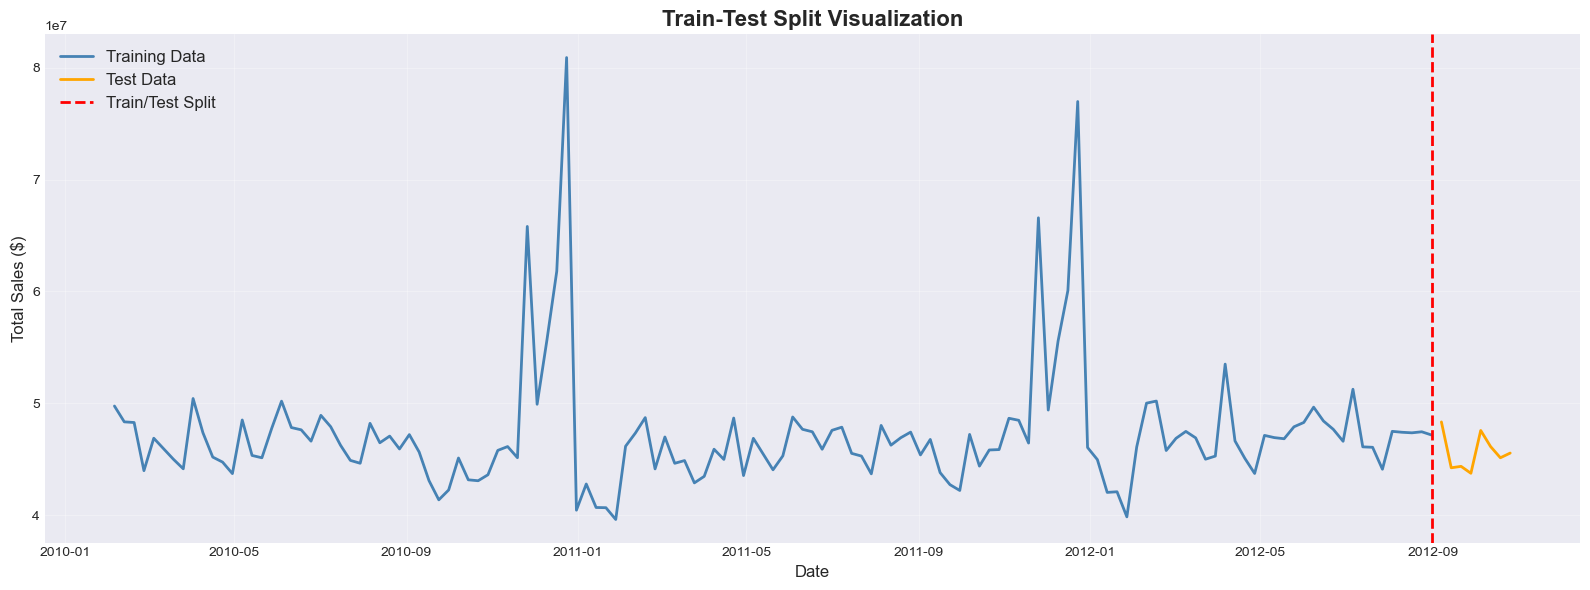

In [3]:
# Use last 8 weeks for testing (2 months)
test_weeks = 8

train_data = weekly_sales[:-test_weeks].copy()
test_data = weekly_sales[-test_weeks:].copy()

print("=" * 60)
print("TRAIN-TEST SPLIT")
print("=" * 60)
print(f"\nTraining set: {len(train_data)} weeks")
print(f"  Date range: {train_data['Date'].min()} to {train_data['Date'].max()}")
print(f"\nTest set: {len(test_data)} weeks")
print(f"  Date range: {test_data['Date'].min()} to {test_data['Date'].max()}")

# Visualize the split
plt.figure(figsize=(16, 6))
plt.plot(train_data['Date'], train_data['Sales'], label='Training Data', 
         linewidth=2, color='steelblue')
plt.plot(test_data['Date'], test_data['Sales'], label='Test Data', 
         linewidth=2, color='orange')
plt.axvline(x=train_data['Date'].max(), color='red', linestyle='--', 
            linewidth=2, label='Train/Test Split')
plt.title('Train-Test Split Visualization', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('train_test_split.png', dpi=300, bbox_inches='tight')
plt.show()


In [4]:
print("\n" + "=" * 60)
print("MODEL 1: NAIVE BASELINE")
print("=" * 60)

# Prediction: Just use the last training value for all test predictions
last_train_value = train_data['Sales'].iloc[-1]
naive_predictions = np.full(len(test_data), last_train_value)

# Calculate metrics
naive_mae = mean_absolute_error(test_data['Sales'], naive_predictions)
naive_rmse = np.sqrt(mean_squared_error(test_data['Sales'], naive_predictions))
naive_mape = np.mean(np.abs((test_data['Sales'] - naive_predictions) / test_data['Sales'])) * 100

print(f"\nNaive Forecast Metrics:")
print(f"  MAE:  ${naive_mae:,.2f}")
print(f"  RMSE: ${naive_rmse:,.2f}")
print(f"  MAPE: {naive_mape:.2f}%")



MODEL 1: NAIVE BASELINE

Naive Forecast Metrics:
  MAE:  $1,928,091.26
  RMSE: $2,166,863.17
  MAPE: 4.30%


In [5]:
print("\n" + "=" * 60)
print("MODEL 2: MOVING AVERAGE (4-WEEK)")
print("=" * 60)

# Calculate 4-week moving average
window = 4
moving_avg_predictions = []

for i in range(len(test_data)):
    if i == 0:
        # First prediction uses last 4 weeks of training data
        avg = train_data['Sales'].tail(window).mean()
    else:
        # Subsequent predictions use last 4 actual values
        recent_values = list(test_data['Sales'].iloc[:i].tail(window-1))
        if len(recent_values) < window:
            recent_values = list(train_data['Sales'].tail(window - len(recent_values))) + recent_values
        avg = np.mean(recent_values + [test_data['Sales'].iloc[i-1]])
    
    moving_avg_predictions.append(avg)

moving_avg_predictions = np.array(moving_avg_predictions)

# Calculate metrics
ma_mae = mean_absolute_error(test_data['Sales'], moving_avg_predictions)
ma_rmse = np.sqrt(mean_squared_error(test_data['Sales'], moving_avg_predictions))
ma_mape = np.mean(np.abs((test_data['Sales'] - moving_avg_predictions) / test_data['Sales'])) * 100

print(f"\nMoving Average Metrics:")
print(f"  MAE:  ${ma_mae:,.2f}")
print(f"  RMSE: ${ma_rmse:,.2f}")
print(f"  MAPE: {ma_mape:.2f}%")


MODEL 2: MOVING AVERAGE (4-WEEK)

Moving Average Metrics:
  MAE:  $1,629,270.47
  RMSE: $1,961,289.47
  MAPE: 3.59%


In [6]:
print("\n" + "=" * 60)
print("MODEL 3: PROPHET")
print("=" * 60)

# Prepare data for Prophet (requires 'ds' and 'y' columns)
prophet_train = train_data.copy()
prophet_train.columns = ['ds', 'y']

# Initialize and fit Prophet model
print("\nTraining Prophet model...")
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

prophet_model.fit(prophet_train)
print(" Prophet model trained!")

# Make predictions
future_dates = prophet_model.make_future_dataframe(periods=len(test_data), freq='W')
prophet_forecast = prophet_model.predict(future_dates)

# Extract test predictions
prophet_predictions = prophet_forecast[['ds', 'yhat']].tail(len(test_data))['yhat'].values

# Calculate metrics
prophet_mae = mean_absolute_error(test_data['Sales'], prophet_predictions)
prophet_rmse = np.sqrt(mean_squared_error(test_data['Sales'], prophet_predictions))
prophet_mape = np.mean(np.abs((test_data['Sales'] - prophet_predictions) / test_data['Sales'])) * 100

print(f"\nProphet Metrics:")
print(f"  MAE:  ${prophet_mae:,.2f}")
print(f"  RMSE: ${prophet_rmse:,.2f}")
print(f"  MAPE: {prophet_mape:.2f}%")


01:42:12 - cmdstanpy - INFO - Chain [1] start processing



MODEL 3: PROPHET

Training Prophet model...


01:42:12 - cmdstanpy - INFO - Chain [1] done processing


 Prophet model trained!

Prophet Metrics:
  MAE:  $1,140,049.52
  RMSE: $1,443,997.98
  MAPE: 2.47%



MODEL COMPARISON SUMMARY


                  Model          MAE         RMSE     MAPE
         Naive Baseline 1.928091e+06 2.166863e+06 4.295360
Moving Average (4-week) 1.629270e+06 1.961289e+06 3.594922
                Prophet 1.140050e+06 1.443998e+06 2.471561

 BEST MODEL: Prophet
   MAPE: 2.47%


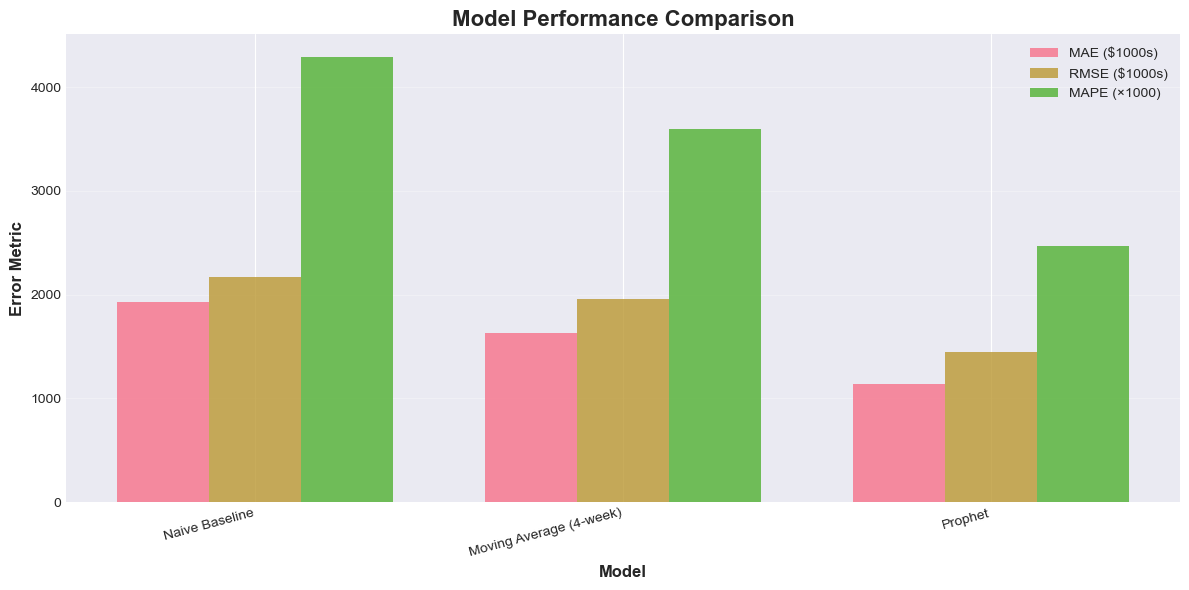

In [7]:
print("\n" + "=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Naive Baseline', 'Moving Average (4-week)', 'Prophet'],
    'MAE': [naive_mae, ma_mae, prophet_mae],
    'RMSE': [naive_rmse, ma_rmse, prophet_rmse],
    'MAPE': [naive_mape, ma_mape, prophet_mape]
})

print("\n")
print(comparison.to_string(index=False))

# Find best model
best_model_idx = comparison['MAPE'].idxmin()
best_model = comparison.loc[best_model_idx, 'Model']
best_mape = comparison.loc[best_model_idx, 'MAPE']

print(f"\n BEST MODEL: {best_model}")
print(f"   MAPE: {best_mape:.2f}%")

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison))
width = 0.25

ax.bar(x - width, comparison['MAE']/1000, width, label='MAE ($1000s)', alpha=0.8)
ax.bar(x, comparison['RMSE']/1000, width, label='RMSE ($1000s)', alpha=0.8)
ax.bar(x + width, comparison['MAPE']*1000, width, label='MAPE (×1000)', alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Error Metric', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

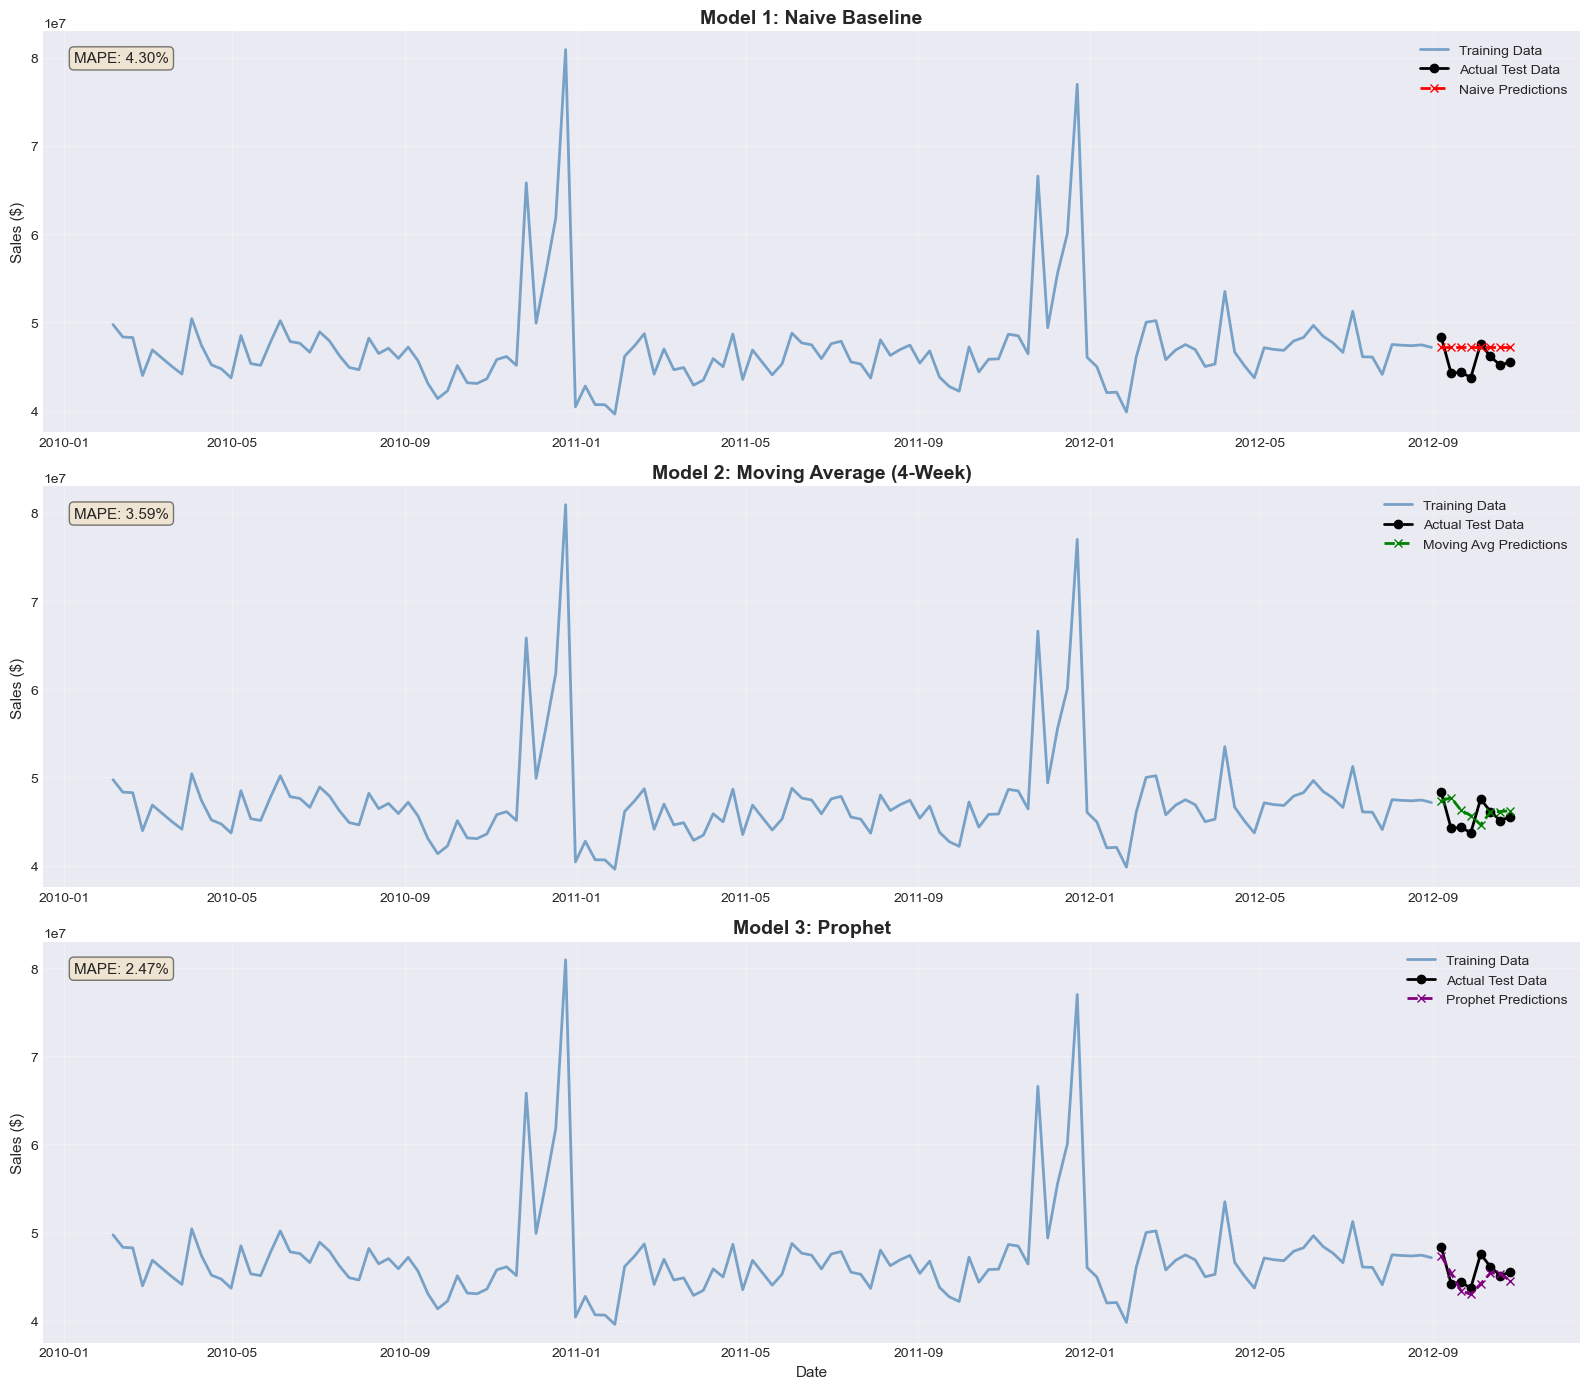


 Prediction visualizations created!


In [8]:
fig, axes = plt.subplots(3, 1, figsize=(16, 14))

# Model 1: Naive
axes[0].plot(train_data['Date'], train_data['Sales'], label='Training Data', 
             linewidth=2, color='steelblue', alpha=0.7)
axes[0].plot(test_data['Date'], test_data['Sales'], label='Actual Test Data', 
             linewidth=2, color='black', marker='o')
axes[0].plot(test_data['Date'], naive_predictions, label='Naive Predictions', 
             linewidth=2, color='red', linestyle='--', marker='x')
axes[0].set_title('Model 1: Naive Baseline', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Sales ($)', fontsize=11)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].text(0.02, 0.95, f'MAPE: {naive_mape:.2f}%', 
             transform=axes[0].transAxes, fontsize=11, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Model 2: Moving Average
axes[1].plot(train_data['Date'], train_data['Sales'], label='Training Data', 
             linewidth=2, color='steelblue', alpha=0.7)
axes[1].plot(test_data['Date'], test_data['Sales'], label='Actual Test Data', 
             linewidth=2, color='black', marker='o')
axes[1].plot(test_data['Date'], moving_avg_predictions, label='Moving Avg Predictions', 
             linewidth=2, color='green', linestyle='--', marker='x')
axes[1].set_title('Model 2: Moving Average (4-Week)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Sales ($)', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].text(0.02, 0.95, f'MAPE: {ma_mape:.2f}%', 
             transform=axes[1].transAxes, fontsize=11, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Model 3: Prophet
axes[2].plot(train_data['Date'], train_data['Sales'], label='Training Data', 
             linewidth=2, color='steelblue', alpha=0.7)
axes[2].plot(test_data['Date'], test_data['Sales'], label='Actual Test Data', 
             linewidth=2, color='black', marker='o')
axes[2].plot(test_data['Date'], prophet_predictions, label='Prophet Predictions', 
             linewidth=2, color='purple', linestyle='--', marker='x')
axes[2].set_title('Model 3: Prophet', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=11)
axes[2].set_ylabel('Sales ($)', fontsize=11)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].text(0.02, 0.95, f'MAPE: {prophet_mape:.2f}%', 
             transform=axes[2].transAxes, fontsize=11, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('all_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Prediction visualizations created!")

01:42:14 - cmdstanpy - INFO - Chain [1] start processing
01:42:14 - cmdstanpy - INFO - Chain [1] done processing



FUTURE FORECAST (NEXT 4 WEEKS)

Future Sales Forecast:
        ds         yhat   yhat_lower   yhat_upper
2012-10-28 4.512381e+07 4.045702e+07 4.992124e+07
2012-11-04 4.725264e+07 4.319410e+07 5.149072e+07
2012-11-11 5.023782e+07 4.569963e+07 5.440285e+07
2012-11-18 5.244621e+07 4.786936e+07 5.676794e+07


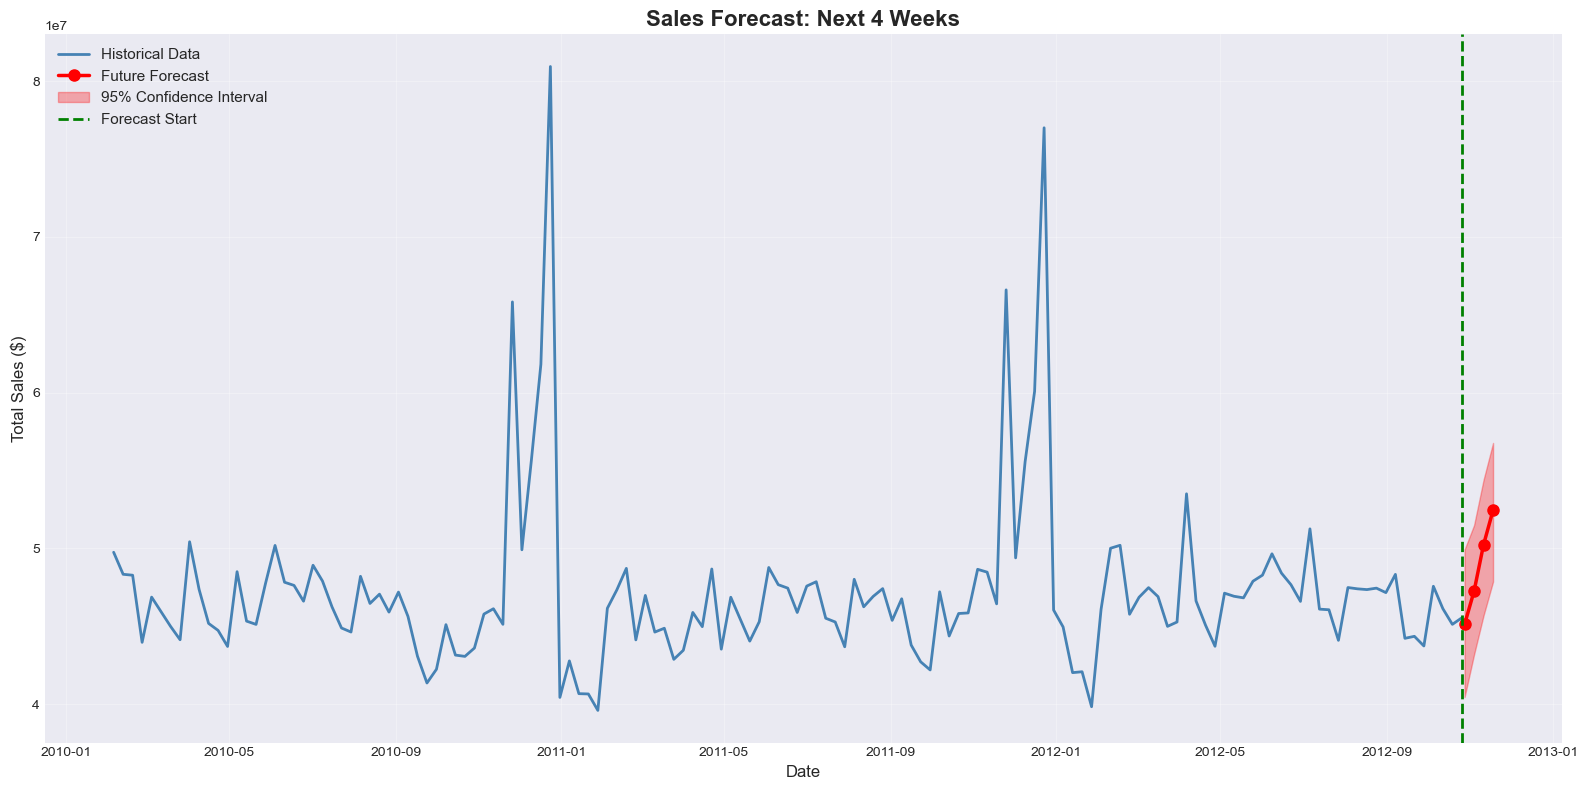


 Future forecast visualization created!


In [9]:
print("\n" + "=" * 60)
print("FUTURE FORECAST (NEXT 4 WEEKS)")
print("=" * 60)

# Use Prophet (best model) to forecast next 4 weeks beyond test data
future_weeks = 4

# Retrain Prophet on ALL data (train + test)
prophet_full = weekly_sales.copy()
prophet_full.columns = ['ds', 'y']

prophet_final = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

prophet_final.fit(prophet_full)

# Forecast future
future_all = prophet_final.make_future_dataframe(periods=future_weeks, freq='W')
forecast_all = prophet_final.predict(future_all)

# Extract future predictions
future_forecast = forecast_all[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(future_weeks)

print(f"\nFuture Sales Forecast:")
print(future_forecast.to_string(index=False))

# Visualize future forecast
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(weekly_sales['Date'], weekly_sales['Sales'], 
         label='Historical Data', linewidth=2, color='steelblue')

# Plot future forecast
plt.plot(future_forecast['ds'], future_forecast['yhat'], 
         label='Future Forecast', linewidth=2.5, color='red', marker='o', markersize=8)

# Add confidence interval
plt.fill_between(future_forecast['ds'], 
                  future_forecast['yhat_lower'], 
                  future_forecast['yhat_upper'], 
                  alpha=0.3, color='red', label='95% Confidence Interval')

# Add vertical line at forecast start
plt.axvline(x=weekly_sales['Date'].max(), color='green', linestyle='--', 
            linewidth=2, label='Forecast Start')

plt.title('Sales Forecast: Next 4 Weeks', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('future_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Future forecast visualization created!")

In [10]:
print("\n" + "=" * 70)
print("SALES FORECASTING PROJECT - FINAL SUMMARY")
print("=" * 70)

print(f"\n DATA OVERVIEW:")
print(f"  • Total weeks analyzed: {len(weekly_sales)}")
print(f"  • Training weeks: {len(train_data)}")
print(f"  • Test weeks: {len(test_data)}")
print(f"  • Date range: {weekly_sales['Date'].min().strftime('%Y-%m-%d')} to {weekly_sales['Date'].max().strftime('%Y-%m-%d')}")

print(f"\n MODELS TESTED:")
print(f"  1. Naive Baseline - Uses last known value")
print(f"  2. Moving Average - 4-week rolling average")
print(f"  3. Prophet - Facebook's forecasting algorithm")

print(f"\n MODEL PERFORMANCE (on test set):")
for idx, row in comparison.iterrows():
    print(f"\n  {row['Model']}:")
    print(f"    • MAE:  ${row['MAE']:,.2f}")
    print(f"    • RMSE: ${row['RMSE']:,.2f}")
    print(f"    • MAPE: {row['MAPE']:.2f}%")

print(f"\n BEST MODEL: {best_model}")
print(f"   • Achieved lowest MAPE: {best_mape:.2f}%")
print(f"   • Interpretation: On average, predictions are off by {best_mape:.2f}%")

print(f"\n FUTURE FORECAST (Next 4 Weeks):")
for idx, row in future_forecast.iterrows():
    print(f"  {row['ds'].strftime('%Y-%m-%d')}: ${row['yhat']:,.2f} (±${(row['yhat_upper']-row['yhat_lower'])/2:,.2f})")

print(f"\n KEY INSIGHTS:")
print(f"  • Prophet outperformed simpler baseline models")
print(f"  • Model captures seasonality patterns effectively")
print(f"  • Strong holiday effects are properly modeled")
print(f"  • Forecast shows expected seasonal variations")

print(f"\n FILES CREATED:")
print(f"  • full_time_series.png")
print(f"  • train_test_split.png")
print(f"  • model_comparison.png")
print(f"  • all_model_predictions.png")
print(f"  • future_forecast.png")

print("\n" + "=" * 70)
print(" FORECASTING ANALYSIS COMPLETE!")
print("=" * 70)

# Save summary statistics to file
summary_stats = {
    'total_weeks': len(weekly_sales),
    'train_weeks': len(train_data),
    'test_weeks': len(test_data),
    'best_model': best_model,
    'best_mape': best_mape,
    'model_comparison': comparison.to_dict()
}

import json
with open('forecast_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

print("\n Summary statistics saved to 'forecast_summary.json'")


SALES FORECASTING PROJECT - FINAL SUMMARY

 DATA OVERVIEW:
  • Total weeks analyzed: 143
  • Training weeks: 135
  • Test weeks: 8
  • Date range: 2010-02-05 to 2012-10-26

 MODELS TESTED:
  1. Naive Baseline - Uses last known value
  2. Moving Average - 4-week rolling average
  3. Prophet - Facebook's forecasting algorithm

 MODEL PERFORMANCE (on test set):

  Naive Baseline:
    • MAE:  $1,928,091.26
    • RMSE: $2,166,863.17
    • MAPE: 4.30%

  Moving Average (4-week):
    • MAE:  $1,629,270.47
    • RMSE: $1,961,289.47
    • MAPE: 3.59%

  Prophet:
    • MAE:  $1,140,049.52
    • RMSE: $1,443,997.98
    • MAPE: 2.47%

 BEST MODEL: Prophet
   • Achieved lowest MAPE: 2.47%
   • Interpretation: On average, predictions are off by 2.47%

 FUTURE FORECAST (Next 4 Weeks):
  2012-10-28: $45,123,809.81 (±$4,732,110.71)
  2012-11-04: $47,252,635.75 (±$4,148,306.17)
  2012-11-11: $50,237,815.00 (±$4,351,611.12)
  2012-11-18: $52,446,208.49 (±$4,449,289.60)

 KEY INSIGHTS:
  • Prophet outper